# PCA Reduction for Cryptos

#### 0. Data Preparation

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()
print(df.columns.tolist())

KeyError: 'Month'

## Using Monthly granularity

### Find the covariance matrix

In [ ]:
import math

# 1. Choose macro variables of interest
nonstablecoin_list = ['Bitcoin', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano']

# 2. Drop NA rows (remove any month with missing data)
nonstablecoin_df = df[nonstablecoin_list].dropna()
print("Shape after dropping NA:", nonstablecoin_df.shape)  # should be (months, 8)

# 3. Transpose: rows = variables, columns = time (as in original SVD method)
data = nonstablecoin_df.T.values
m, n = data.shape

Shape after dropping NA: (84, 6)


In [ ]:
# 4. Covariance matrix
S = np.cov(data)
print("Covariance matrix S:\n", S)

# 5. Correlation matrix
print("Correlation matrix:\n", np.corrcoef(data))

# 6. Eigenvalues (for total variance)
eigvals = np.linalg.eigvals(S)
print("Eigenvalues of covariance matrix:\n", eigvals)
print("Total variance:", np.sum(eigvals))

# 7. Recentered data matrix B
recentered_data = (data - data.mean(axis=1).reshape(-1, 1)) / math.sqrt(n - 1)
print("Recentered data matrix B:\n", recentered_data)

# 8. SVD of transposed recentered data
u, s, Pt = np.linalg.svd(recentered_data.T)
P = Pt.T  # P contains eigenvectors (principal directions)

# 9. Transform data: PC scores
transformed_data = Pt @ data
print("Transformed data (y = P^T x):\n", transformed_data)

# get the principle components, which are the columns of P
print('The first principle component is \n', P[:,0], '\n')
print('The second principle component is \n', P[:,1], '\n')

# getting the covariance matrix of the transformed data
D = np.matrix.round(np.diag(eigvals), decimals=2)
print('The covariance matrix, D, of the transformed data is the diagonal matrix of the eigenvalues, which is \n', D, '\n')

# get the total variance of the transformed data
print('The total variance is \n', np.sum(eigvals), '\n')

# calculate the % of total variance --> this is wrong
#var_list = [ eigvals[0], eigvals[1], eigvals[2], eigvals[3], eigvals[4] ]/np.sum(eigvals)*100
#print('The percentage of total variance covered by deuterium, CO2, CH4, dust, and calcium, respectively, are \n', var_list)

Covariance matrix S:
 [[0.16538984 0.12706938 0.13503196 0.13190139 0.13220693        nan]
 [0.12706938 0.16727208 0.16930088 0.13438341 0.14431133        nan]
 [0.13503196 0.16930088 0.28315871 0.14760129 0.2211262         nan]
 [0.13190139 0.13438341 0.14760129 0.16616413 0.14276486        nan]
 [0.13220693 0.14431133 0.2211262  0.14276486 0.46415721        nan]
 [       nan        nan        nan        nan        nan        nan]]
Correlation matrix:
 [[1.         0.76396732 0.62397502 0.79565779 0.47716352        nan]
 [0.76396732 1.         0.77791567 0.80605615 0.51791223        nan]
 [0.62397502 0.77791567 1.         0.68046621 0.60994784        nan]
 [0.79565779 0.80605615 0.68046621 1.         0.51406749        nan]
 [0.47716352 0.51791223 0.60994784 0.51406749 1.                nan]
 [       nan        nan        nan        nan        nan        nan]]


LinAlgError: Array must not contain infs or NaNs

### Rank-1 approximation

In [ ]:
# 10. Rank-1 approximation
k = 1
P_trunc = P[:, :k]                    # first k eigenvectors
transformed_trunc = transformed_data[:k, :]  # first k PC scores
approx1 = P_trunc @ transformed_trunc

# 11. Evaluate: correlation between original and approx1 for each macro
for i, macro in enumerate(nonstablecoin_list):
    corr = np.corrcoef(approx1[i], data[i])[0, 1]
    print(f"Correlation between original and rank-1 approx for {macro}: {corr:.4f}")

Correlation between original and rank-1 approx for Bitcoin: 0.7648
Correlation between original and rank-1 approx for Litecoin: 0.8429
Correlation between original and rank-1 approx for XRP: 0.8704
Correlation between original and rank-1 approx for Ethereum: 0.8342
Correlation between original and rank-1 approx for Dogecoin: 0.8197
Correlation between original and rank-1 approx for Cardano: 0.8459


### Rank-2 approximation

In [ ]:
# 10. Rank-1 approximation
k = 2
P_trunc = P[:, :k]                    # first k eigenvectors
transformed_trunc = transformed_data[:k, :]  # first k PC scores
approx1 = P_trunc @ transformed_trunc

# 11. Evaluate: correlation between original and approx1 for each macro
for i, macro in enumerate(nonstablecoin_list):
    corr = np.corrcoef(approx1[i], data[i])[0, 1]
    print(f"Correlation between original and rank-1 approx for {macro}: {corr:.4f}")

Correlation between original and rank-1 approx for Bitcoin: 0.8440
Correlation between original and rank-1 approx for Litecoin: 0.9179
Correlation between original and rank-1 approx for XRP: 0.8808
Correlation between original and rank-1 approx for Ethereum: 0.9140
Correlation between original and rank-1 approx for Dogecoin: 0.9973
Correlation between original and rank-1 approx for Cardano: 0.8994


## Visualization of PCA Outcome

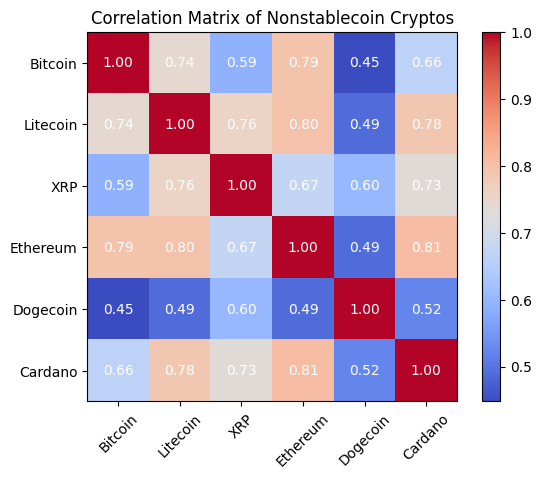

In [ ]:
# plot correlation matrix for the original data
Cor_matrix = np.corrcoef(data)
plt.imshow(Cor_matrix)
plt.colorbar()
plt.set_cmap('coolwarm')
plt.title('Correlation Matrix of Nonstablecoin Cryptos')

for i in range(6):
    for j in range(6):
        plt.text(j, i, f'{Cor_matrix[i, j]:.2f}',
                 ha='center', va='center', color='white')
plt.xticks(range(6), ['Bitcoin', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano'], rotation=45)
plt.yticks(range(6), ['Bitcoin', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano'])

plt.show()

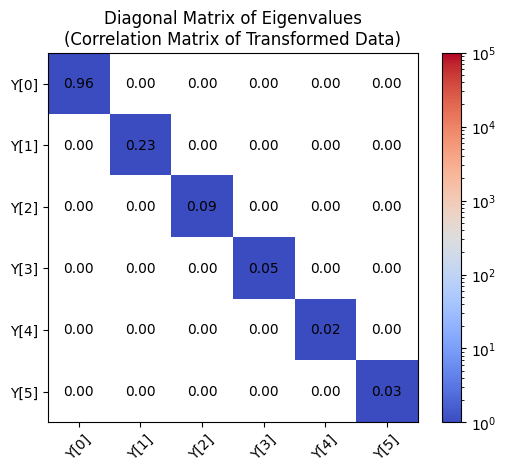

In [ ]:
# plot the correlation matrix of the transformed data,
# which is the diagonal matrix of eigenvalues
from matplotlib.colors import LogNorm

plt.imshow(D, cmap='coolwarm', norm=LogNorm(vmin=1e0, vmax=1e5))
plt.colorbar()
plt.title('Diagonal Matrix of Eigenvalues' + "\n"  +
          '(Correlation Matrix of Transformed Data)')

for i in range(6):
    for j in range(6):
        plt.text(j, i, f'{D[i, j]:.2f}',
                 ha='center', va='center', color='black')
plt.xticks(range(6), ['Y[0]', 'Y[1]', 'Y[2]', 'Y[3]', 'Y[4]', 'Y[5]'], rotation=45)
plt.yticks(range(6), ['Y[0]', 'Y[1]', 'Y[2]', 'Y[3]', 'Y[4]', 'Y[5]'])

plt.show()

In [ ]:
# Only use the time index corresponding to the rows actually used in PCA (after dropping NaNs)
valid_idx = df[nonstablecoin_list].dropna().index  # ✅ Use this instead
index = valid_idx

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

num_macros = len(nonstablecoin_list)
fig, axs = plt.subplots(nrows=3 * num_macros, ncols=1, figsize=(12, 3 * num_macros), sharex=True)

for i, macro_name in enumerate(nonstablecoin_list):
    macro_index = i

    approx1 = P[:, :1] @ transformed_data[:1, :]
    approx2 = P[:, :2] @ transformed_data[:2, :]

    original = data[macro_index]
    approx_1_series = approx1[macro_index]
    approx_2_series = approx2[macro_index]

    # Plot Rank 1 Approximation
    axs[3*i].plot(valid_idx, approx_1_series, color='tab:blue')
    axs[3*i].set_title(f'{macro_name} - Rank 1 Approximation')
    axs[3*i].set_ylabel(macro_name)
    axs[3*i].set_xticks([])

    # Plot Rank 2 Approximation
    axs[3*i + 1].plot(valid_idx, approx_2_series, color='tab:orange')
    axs[3*i + 1].set_title(f'{macro_name} - Rank 2 Approximation')
    axs[3*i + 1].set_ylabel(macro_name)
    axs[3*i + 1].set_xticks([])

    # Plot Original Data
    axs[3*i + 2].plot(valid_idx, original, color='tab:green')
    axs[3*i + 2].set_title(f'{macro_name} - Original Data')
    axs[3*i + 2].set_ylabel(macro_name)
    axs[3*i + 2].set_xlabel('Time')

    axs[3*i + 2].xaxis.set_major_locator(mdates.MonthLocator())
    axs[3*i + 2].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(axs[3*i + 2].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

import numpy as np

# Assuming D is your diagonal eigenvalue matrix
# Get eigenvalues as a 1D array from D
eigenvalues = np.diag(D)

# Total variance
total_variance = np.sum(eigenvalues)

# Variance captured by rank-1 and rank-2
variance_rank1 = np.sum(eigenvalues[:1])
variance_rank2 = np.sum(eigenvalues[:2])

# Explained variance ratios
explained_ratio_rank1 = variance_rank1 / total_variance
explained_ratio_rank2 = variance_rank2 / total_variance

print(f"Explained Variance Ratio - Rank 1: {explained_ratio_rank1:.4f} ({explained_ratio_rank1*100:.2f}%)")
print(f"Explained Variance Ratio - Rank 2: {explained_ratio_rank2:.4f} ({explained_ratio_rank2*100:.2f}%)")

NameError: name 'df' is not defined

## Add new PC macros to sheet

In [ ]:
# Step 1: Choose rank
k = 2

# Step 2: Truncate eigenvectors and scores
P_trunc = P[:, :k]                          # shape: (n_macros, 2)
transformed_trunc = transformed_data[:k, :]  # shape: (2, n_timepoints)

# Step 3: Transpose scores to get time series for PC1 and PC2
pcs = transformed_trunc.T  # shape: (n_timepoints, 2)

# Step 4: Use the cleaned index used in PCA
valid_idx = df[nonstablecoin_list].dropna().index
pc_df = pd.DataFrame(pcs, columns=['PC1_crypto', 'PC2_crypto'], index=valid_idx)

# Step 5: Add to your original sheet
df_augmented = pd.concat([df, pc_df], axis=1)

# Optional: overwrite original df if you want
# df = df_augmented

# Confirm
print(df_augmented.head())
df_augmented.to_excel('data/Monthly Mastersheet.xlsx')


             Bitcoin   Tether  Litecoin       XRP  Ethereum  Dogecoin  \
2017-09-01 -1.398923 -3.82830  -1.02849 -0.898590 -1.320943 -1.405018   
2017-10-01 -1.339539 -3.73861  -0.77151 -1.145490 -0.837982 -0.464897   
2017-11-01 -1.622995 -4.01951  -1.44830 -1.192080 -1.837874 -1.371050   
2017-12-01 -1.267670 -2.55687  -1.11575 -1.254630 -1.310402 -0.702095   
2018-01-01 -0.892511 -2.75193  -0.24164  0.038975 -0.811280 -0.334438   

            Cardano  USD Coin    VIX   MOVE  ...  vol_r  vol_M1  vol_GDP  \
2017-09-01      NaN       NaN  10.59  52.88  ...    NaN     NaN      NaN   
2017-10-01      NaN       NaN   9.51  51.15  ...    NaN     NaN      NaN   
2017-11-01      NaN       NaN  10.18  46.83  ...    NaN     NaN      NaN   
2017-12-01      NaN       NaN  11.28  46.60  ...    NaN     NaN      NaN   
2018-01-01      NaN       NaN  11.04  57.20  ...    NaN     NaN      NaN   

            vol_IM  vol_EX  vol_CC    PC1_macro     PC2_macro  PC1_crypto  \
2017-09-01     NaN     NaN 